# Step 5: Feature Engineering for NYC 311 Modeling

This notebook demonstrates the complete feature engineering pipeline for three modeling tracks:
1. **Forecast** - Time-series forecasting of ticket arrivals
2. **Triage** - Ticket prioritization at creation time
3. **Duration** - Survival modeling for time-to-close

All features are **leakage-safe** and use **H3-based spatial grouping**.


In [1]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


from src import preprocessing
from src import features
from src import config
from src import forecast

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
from importlib import reload

## Usage Instructions

This notebook uses the feature engineering module from `src/features.py`.

To run this notebook:
1. Ensure you have data in `data/landing/311-service-requests/`
2. Run `pip install -r requirements.txt` to install dependencies
3. Execute cells sequentially

For detailed documentation, see `src/FEATURE_ENGINEERING_README.md`


In [2]:
df_orig = preprocessing.preprocess_and_merge_external_data()

Loading DOHMH data...
Data Shape: (1029643, 27)
Preprocessing DOHMH data...
Data Shape: (671735, 44)
Merging census data...
Data Shape: (671735, 48)
Merging weather data...
Data Shape: (657874, 59)

Final Data Shape: (657874, 59)


In [3]:
reload(features)

<module 'src.features' from 'c:\\Users\\gorav\\GitHub\\nyc-311-service-requests\\src\\features.py'>

In [4]:
df = df_orig.copy()
forecast_panel = features.build_forecast_panel(df)



### Explore Feature Interactions

In [5]:
def filter_data(X, y):
    """
    Filter and X and Y based off of null values in X

        Parameters:
            X: DataFrame of features
            y: Series of target values
        Returns:
            X_transformed: subsetted DataFrame
            y_transformed: subsetted Series
    """
    nan_mask = pd.isnull(X).any(axis=1)
    X_transformed = X[~nan_mask]
    y_transformed = y[~nan_mask]
    print("X shape post-filtering:", X_transformed.shape)
    return X_transformed, y_transformed

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

# -----------------------------
# Helpers
# -----------------------------

def select_features(X, feature_list):
    """
    Select columns from X based off of list

        Parameters:
            X: DataFrame of features transformation
            feature_list: list of features
        Returns:
            X: DataFrame of subsetted columns
    """
    X = X[feature_list].copy()
    return X


def filter_data(X, y):
    """
    Filter X and y based on null values in X

        Parameters:
            X: DataFrame of features
            y: Series of target values
        Returns:
            X_transformed: subsetted DataFrame
            y_transformed: subsetted Series
    """
    nan_mask = pd.isnull(X).any(axis=1)
    X_transformed = X[~nan_mask]
    y_transformed = y[~nan_mask]
    print("X shape post-filtering:", X_transformed.shape)
    return X_transformed, y_transformed


def split_train_test_by_cutoff(X, y, date_column='day', cutoff='2024-01-01'):
    """Split X and y by a date cutoff where test >= cutoff.
    Returns X_train, X_test, y_train, y_test
    """
    cutoff = pd.Timestamp(cutoff)
    mask_test = pd.to_datetime(X[date_column]) >= cutoff
    X_train, X_test = X[~mask_test].copy(), X[mask_test].copy()
    y_train, y_test = y.loc[X_train.index].copy(), y.loc[X_test.index].copy()
    return X_train, X_test, y_train, y_test


def make_time_based_cv(X, n_splits=5, date_column='day', max_train_size=None):
    """Create a TimeSeriesSplit configured for the provided data order.
    Assumes X is already sorted by date ascending.
    """
    # The splitter will use the row order, so ensure we are sorted
    assert X[date_column].is_monotonic_increasing, (
        "X must be sorted ascending by date_column for TimeSeriesSplit"
    )
    return TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size)


# -----------------------------
# Main fit function
# -----------------------------

def fit_pipeline(
    df_input,
    regressor,
    target_column,
    input_columns,
    numerical_columns,
    categorical_columns,
    date_column='week',
    test_cutoff='2024-01-01',
    cv_splits=5,
    cv_scoring=None,
    cv_max_train_size=None,
):
    """
    Fit pipeline with a fixed train/test split where test is 2024-01-01 onwards.
    Performs time-based (expanding window) cross-validation on the TRAIN ONLY.

    Parameters:
        df_input: input DataFrame
        regressor: sklearn-compatible regressor
        target_column: str, target name
        input_columns: list of columns to use as model inputs
        numerical_columns: list of numeric columns (passed through)
        categorical_columns: list of categorical columns (one-hot)
        date_column: str, name of date column (default 'day')
        test_cutoff: str | timestamp, boundary where test >= cutoff (default '2024-01-01')
        cv_splits: int, number of time-based CV splits on train (default 5)
        cv_scoring: str | callable, sklearn scoring for CV (optional)
        cv_max_train_size: int | None, optional cap for train size in each fold

    Returns:
        pipeline: fitted sklearn pipeline
        X_train, X_test, y_train, y_test: the split datasets
        cv_scores: list | None of CV scores (if scoring provided)
        cv_splitter: the TimeSeriesSplit instance used
    """
    # Sort by date ascending
    df = df_input.sort_values(by=date_column).reset_index(drop=True)

    # Build features/target
    feature_list = numerical_columns + categorical_columns
    X = df[input_columns].copy()
    y = df[target_column].copy()

    print("X shape pre-filtering:", X.shape)
    X, y = filter_data(X, y)

    # Enforce datetime
    X[date_column] = pd.to_datetime(X[date_column])

    # Fixed cutoff split: test is 2024+
    X_train, X_test, y_train, y_test = split_train_test_by_cutoff(
        X, y, date_column=date_column, cutoff=test_cutoff
    )

    print(
        f"Train dates [{X_train[date_column].min()} to {X_train[date_column].max()}], "
        f"Test dates [{X_test[date_column].min()} to {X_test[date_column].max()}]"
    )
    print("X training shape:", X_train.shape)
    print("X test shape:", X_test.shape)

    # Preprocessor: OHE for categoricals; pass-through numerics
    preprocessor = ColumnTransformer(
        transformers=[
            (
                "one_hot_encoder",
                OneHotEncoder(handle_unknown="ignore", drop="first"),
                categorical_columns,
            ),
        ],
        remainder="passthrough",  # keep numeric columns
    )

    pipeline = Pipeline(
        steps=[
            (
                "select_features",
                FunctionTransformer(select_features, kw_args={"feature_list": feature_list}),
            ),
            ("preprocessor", preprocessor),
            ("regressor", regressor),
        ]
    )

    # -----------------------------
    # Time-based CV on TRAIN ONLY
    # -----------------------------
    # Ensure train is sorted (it already is by construction, but be explicit)
    X_train = X_train.sort_values(by=date_column)
    y_train = y_train.loc[X_train.index]

    cv_splitter = make_time_based_cv(
        X_train, n_splits=cv_splits, date_column=date_column, max_train_size=cv_max_train_size
    )

    cv_scores = None
    if cv_scoring is not None:
        # Evaluate with CV on the training set only
        cv_scores = cross_val_score(
            pipeline, X_train, y_train, cv=cv_splitter, scoring=cv_scoring, n_jobs=None
        )
        print(f"CV ({cv_scoring}) scores:", cv_scores)
        print("CV mean:", cv_scores.mean())

    # Fit final model on all TRAIN data
    pipeline.fit(X_train, y_train)

    return pipeline, X_train, X_test, y_train, y_test, cv_scores, cv_splitter


In [7]:
reload(forecast)

<module 'src.forecast' from 'c:\\Users\\gorav\\GitHub\\nyc-311-service-requests\\src\\forecast.py'>

In [16]:
family = config.COMPLAINT_FAMILIES[0]
horizons = range(1,5)
horizon = 4


numerical_columns = [
            'lag1', 'lag4', 'roll4', 'roll12',
            'momentum', 'weeks_since_last',
            'tavg', 'prcp', 'heating_degree', 'cooling_degree',
            'rain_3d', 'rain_7d', 'log_pop', 'nbr_roll4', 'nbr_roll12'
        ]

categorical_columns = ['week_of_year', 'heat_flag', 'freeze_flag', 'hex6', 'complaint_family']

# df = forecast_panel[forecast_panel['complaint_family'] == family].copy()
df = forecast_panel.copy()
df = forecast.create_horizon_targets(df, [horizon])


In [17]:
df_input = df.copy()

params = {
            'objective': 'poisson',
            'n_estimators': 800,
            'learning_rate': 0.05,
            'max_depth': 6,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_samples': 20,
            'random_state': 42,
            'verbose': -1
        }


tweedie_params = {
    "objective": "tweedie",
    "tweedie_variance_power": 1.3,   # try 1.1–1.6 during tuning
    "learning_rate": 0.05,
    "n_estimators": 1200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

regressor = LGBMRegressor(**params)
target_column = f'y_h{horizon}'
cv_scoring = mean_absolute_error
input_columns = df_input.columns.tolist()

In [18]:
pipeline, X_train, X_test, y_train, y_test, cv_scores, cv_splitter = fit_pipeline(
    df_input, regressor, target_column, input_columns, numerical_columns, categorical_columns, cv_scoring = 'neg_mean_absolute_error'
)

X shape pre-filtering: (441216, 28)
X shape post-filtering: (423987, 28)
Train dates [2010-03-16 00:00:00 to 2023-12-26 00:00:00], Test dates [2024-01-02 00:00:00 to 2025-07-29 00:00:00]
X training shape: (391415, 28)
X test shape: (32572, 28)
CV (neg_mean_absolute_error) scores: [-0.60578792 -0.67514103 -0.67523202 -0.6322775  -0.56942627]
CV mean: -0.6315729502845749


In [19]:
cv_scores

array([-0.60578792, -0.67514103, -0.67523202, -0.6322775 , -0.56942627])

In [20]:
reload(forecast)

<module 'src.forecast' from 'c:\\Users\\gorav\\GitHub\\nyc-311-service-requests\\src\\forecast.py'>

In [21]:
y_pred = pipeline.predict(X_test)
forecast.eval_forecast(y_test, y_pred, family, horizon)


{'family': 'vector_control',
 'horizon': 4,
 'rmse': 1.3568657236515171,
 'mae': 0.6137514665812467,
 'mape': 260534221757.72983,
 'poisson_deviance': 1.071359240333335,
 'n_samples': 32572}

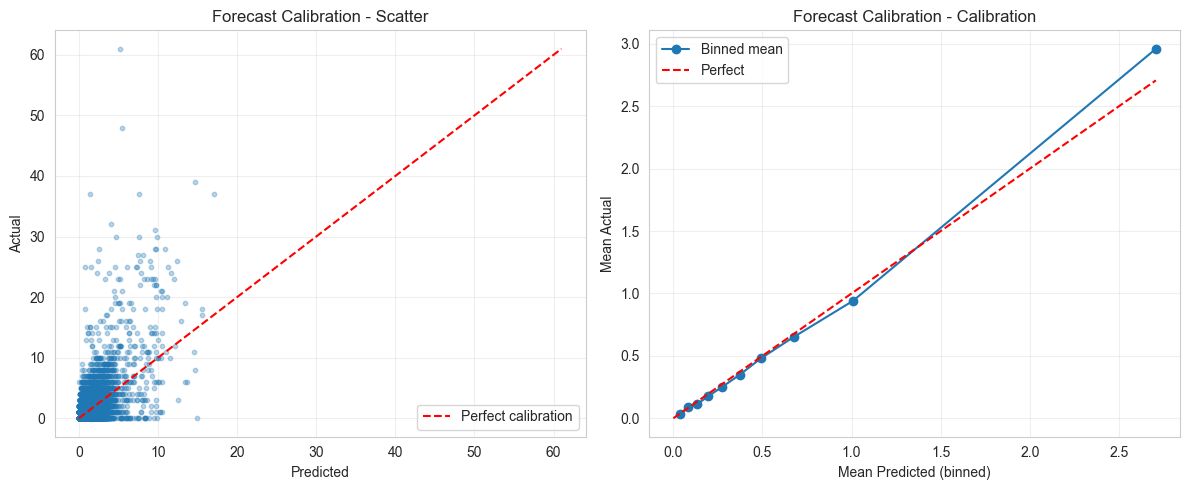

In [22]:
forecast.plot_forecast_calibration(y_test, y_pred)

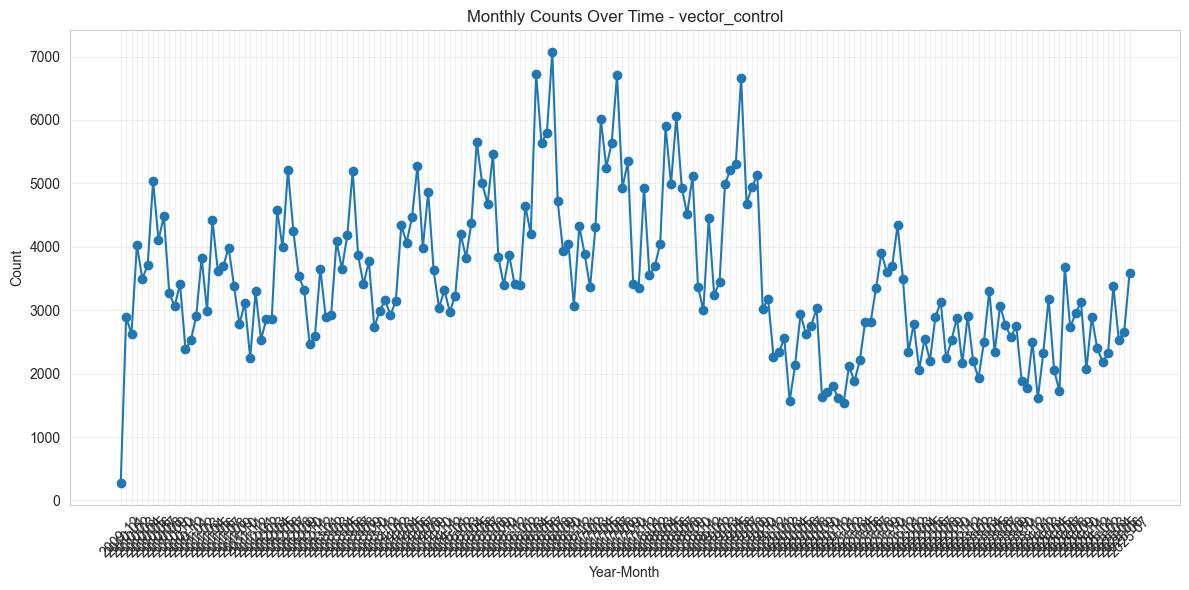

,year_month,y
0,2009-12,274.0
1,2010-01,2886.0
2,2010-02,2629.0
3,2010-03,4029.0
4,2010-04,3497.0
...,...,...
183,2025-03,2320.0
184,2025-04,3377.0
185,2025-05,2534.0
186,2025-06,2659.0


In [23]:
# Plot counts over time by year-month
df_plot = df_input[df_input['week'] >= '2022-01-01'].copy()
df_plot = df_input.copy()
df_plot['year_month'] = df_plot['week'].dt.to_period('M')
monthly_counts = df_plot.groupby('year_month')['y'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts['year_month'].astype(str), monthly_counts['y'], marker='o')
plt.title(f'Monthly Counts Over Time - {family}')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

monthly_counts

In [ ]:
bundles = forecast.train_all_families(
    panel, 
    families=config.COMPLAINT_FAMILIES,
    horizons=range(1, 8),  # 1-7 days
    val_days=30  # Last 30 days for validation
)

In [ ]:
last_rows = panel.groupby(['hex', 'complaint_family']).last().reset_index()

# Predict 7 days ahead
predictions = forecast.predict_forecast(bundles, last_rows, horizon=7)

In [ ]:
last_rows

In [ ]:
predictions

In [ ]:
# triage_features, tfidf_matrix, vectorizer = features.build_triage_features(df)
# duration_labels = features.build_duration_survival_labels(df)
# duration_features = features.build_duration_features(df, triage_features)
